In [99]:
import hoomd
from hoomd.md import bond, angle
import gsd
import gsd.hoomd
import numpy
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import matplotlib.pyplot as plt


def run_one(bondk=500, anglek=400):
    device = hoomd.device.CPU()
    # device = hoomd.device.GPU()
    simulation = hoomd.Simulation(device = device, seed = 2)

    #initialize 3 atoms
    N = 3
    L = 5
    frame = gsd.hoomd.Frame()
    frame.configuration.box = [L, L, L, 0, 0, 0]

    #make three particles
    frame.particles.N = N
    frame.particles.position = [[-.55,.55,0],[0,0,0],[.55,.55,0]]
    frame.particles.mass = [1.0] * N
    frame.particles.types = ['A']
    frame.particles.typeID = [0] * N

    #set two bonds
    frame.bonds.N=2
    frame.bonds.types = ['A-A']
    frame.bonds.typeID = [0]*2
    frame.bonds.group = numpy.array([[0,1],[1,2]])

    #and an angle
    frame.angles.N=1
    frame.angles.types = ['A-A-A']
    frame.angles.typeID = [0]
    frame.angles.group = numpy.array([[0,1,2]])
    
    with gsd.hoomd.open(name='smol.gsd', mode='a') as f:
        f.append(frame)
    simulation.create_state_from_gsd(filename='smol.gsd')

    harmonic = bond.Harmonic()
    harmonic.params['A-A'] = dict(k=bondk, r0=1.5)
    angles = angle.Harmonic()
    angles.params['A-A-A'] = dict(k=anglek, t0=1.7)
    kT = 1.1
    

    integrator = hoomd.md.Integrator(dt = 0.005)
    integrator.forces.append(harmonic)
    integrator.forces.append(angles)

    nvt = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.Tags([0,1,2]), 
                                          thermostat = hoomd.md.methods.thermostats.Bussi(kT = kT))
    integrator.methods.append(nvt)
    
    simulation.operations.integrator = integrator
    simulation.state.thermalize_particle_momenta(filter=hoomd.filter.Tags([0,1,2]), kT=kT)
    
    gsd_writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="traj.gsd", mode='wb', filter=hoomd.filter.All())
    simulation.operations.writers.append(gsd_writer)
    simulation.run(1000)



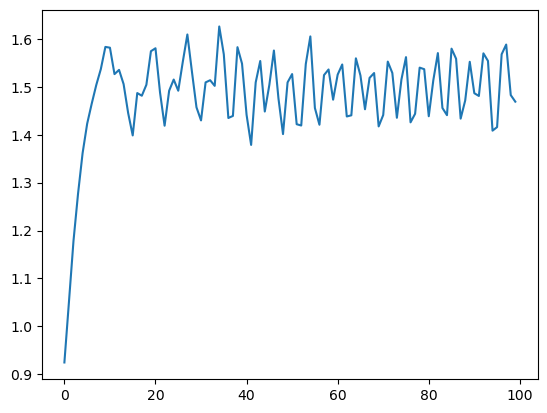

In [94]:

run_one(bondk=500, anglek=400)
u = mda.Universe("traj.gsd")
atoms = u.select_atoms("index 0 1")
bondlength = [distances.self_distance_array(atoms) for ts in u.trajectory]
plt.plot(bondlength)

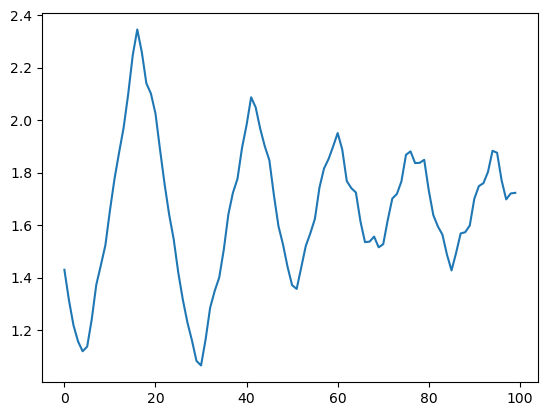

In [101]:
import numpy
run_one(bondk=500, anglek=40)
u = mda.Universe("traj.gsd")
a0 = u.atoms[0]
a1 = u.atoms[1]
a2 = u.atoms[2]
angle1 = []
for ts in u.trajectory:
    r1 = a0.position-a1.position
    r1 /= numpy.linalg.norm(r1)
    r2 = a2.position-a1.position
    r2 /= numpy.linalg.norm(r2)
    angle1.append(numpy.arccos(numpy.dot(r1,r2)))
    
#angle = [distances.self_distance_array(atoms) for ts in u.trajectory]
plt.plot(angle1)